In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()
import warnings
import math
warnings.filterwarnings('ignore')
tf.set_random_seed(111)

In [18]:
df = pd.read_csv('../dataset/BUD_HK.csv')
df.head()

,trade_date,open,high,low,close,pre_close,vol
0,20200303,23.50,23.50,23.00,23.3,23.2,9489528
1,20200302,23.25,23.55,23.05,23.2,23.4,12318033
2,20200228,23.30,23.60,23.10,23.4,24.0,23639398
3,20200227,23.65,24.00,23.35,24.0,24.3,18638109
4,20200226,23.10,24.35,23.10,24.3,23.6,12841991


In [19]:
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime
df['trade_date']=df['trade_date'].apply(time2stamp)
df=df.sort_values(by='trade_date')
df.reset_index(inplace=True,drop=True)
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

In [20]:
history_date=np.arange('2019-09-30','2020-03-04',dtype='datetime64[D]')

In [21]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.457447,0.590164,0.500000,0.537635,0.408602,1.000000
1,0.542553,0.688524,0.588235,0.698925,0.537635,0.370725
2,0.680851,0.715847,0.711765,0.688172,0.698925,0.209729
3,0.696809,0.797814,0.741176,0.784946,0.688172,0.147366
4,0.765957,0.939890,0.829412,0.903226,0.784946,0.308616


In [22]:
num_layers = 1
size_layer = 128
timestamp = 6
epoch = 1000
dropout_rate = 0.7
future_day = 30

In [23]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        attention_size = 10,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.name_scope('LSTM_layer'):
            rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],state_is_tuple = False,)
            
            self.X = tf.placeholder(tf.float32, (None, None, size),name='input_x')  # (win,1,features)
            self.Y = tf.placeholder(tf.float32, (None, output_size),name='input_y') # (win,features)
            
            with tf.name_scope('Dropout_layer'):
                drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)

            self.hidden_layer = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer),name='rnn_init')
            
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32)  
            
            # output: [batch_size, window_size, units] 没有attention的话，往后传的是output
            # state: [batch_size,units]   作为attention
        with tf.name_scope('attention_layer'):
            attention_w = tf.get_variable('attention_w', [attention_size], tf.float32) # （10，） values
            print('attention_w: ',attention_w.shape)
            
            with tf.name_scope('query_dense'):
                query = tf.layers.dense(tf.expand_dims(self.last_state[:, size_layer:], 1), attention_size)
                print('query: ',query.shape)
            
            with tf.name_scope('keys_dense'):
                keys = tf.layers.dense(self.outputs, attention_size)
                print('keys: ',keys.shape)
            
            mm=tf.tanh(keys + query)
            print('mm: ',mm.shape)
            align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])  
            align = tf.tanh(align) # (-1,1),相当于softmax(0,1)
            print('align: ',align.shape)
            
            self.outputs = tf.squeeze(
                tf.matmul(tf.transpose(self.outputs, [0, 2, 1]), tf.expand_dims(align, 2)),2,)  # outputs->attention_map=sum(a*V)  ->(5,128)
            print('outputs: ',self.outputs.shape)
        
        with tf.name_scope('output_dense'):
            self.logits = tf.layers.dense(self.outputs, output_size)
        
        with tf.name_scope('cost'):
            self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))  # 平均损失函数mse
        
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [24]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)
sess.run(tf.local_variables_initializer())
writer = tf.summary.FileWriter('logs/',sess.graph)

attention_w:  (10,)
query:  (?, 1, 10)
keys:  (?, ?, 10)
mm:  (?, ?, 10)
align:  (?, ?)
outputs:  (?, 128)


In [25]:
## 训练，batch_size=1,误差mse
for i in range(epoch):
    init_value = np.zeros((timestamp, num_layers * 2 * size_layer))
    total_loss = 0
    acc_list=[]
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index].values, axis = 1)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,},)
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 10 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 10 avg loss: 0.043583841939621115
epoch: 20 avg loss: 0.03334174583227757
epoch: 30 avg loss: 0.007592083516475909
epoch: 40 avg loss: 0.02576491209294866
epoch: 50 avg loss: 0.0076938423273317956
epoch: 60 avg loss: 0.005785738679525607
epoch: 70 avg loss: 0.005746472609804615
epoch: 80 avg loss: 0.003562303468831541
epoch: 90 avg loss: 0.007346119899439681
epoch: 100 avg loss: 0.005021051798180184
epoch: 110 avg loss: 0.004651920822010759
epoch: 120 avg loss: 0.007836771392783918
epoch: 130 avg loss: 0.007424622822059866
epoch: 140 avg loss: 0.009977646421997206
epoch: 150 avg loss: 0.003421038272790611
epoch: 160 avg loss: 0.0035158058060059216
epoch: 170 avg loss: 0.006947450600016643
epoch: 180 avg loss: 0.004887431534691988
epoch: 190 avg loss: 0.009801809874582379
epoch: 200 avg loss: 0.00476653257261633
epoch: 210 avg loss: 0.0077353738152476795
epoch: 220 avg loss: 0.00423298151615788
epoch: 230 avg loss: 0.0025260473861742545
epoch: 240 avg loss: 0.002881234121399329
e

In [26]:
# 多步训练，单步预测
## 预测历史数据
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((timestamp, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 1),
            modelnn.hidden_layer: init_value,
        },)
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

## 对尾部不能被win整除的数据，单独预测（Model中没有限制第一维win，所以此处时间窗即使不到win也能预测结果）
## 得到的last_state作为dynamic_RNNde init
expanded = np.expand_dims(df_log.iloc[upper_b:], axis = 1)
out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: expanded,
        modelnn.hidden_layer: init_value[-expanded.shape[0] :],
    },)
init_value[-expanded.shape[0] :] = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

## 预测未来多个时间，只保留最后一个时间步。相当于单步预测
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 1),
            modelnn.hidden_layer: init_value,
        },)
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1] # 不间断
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [27]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

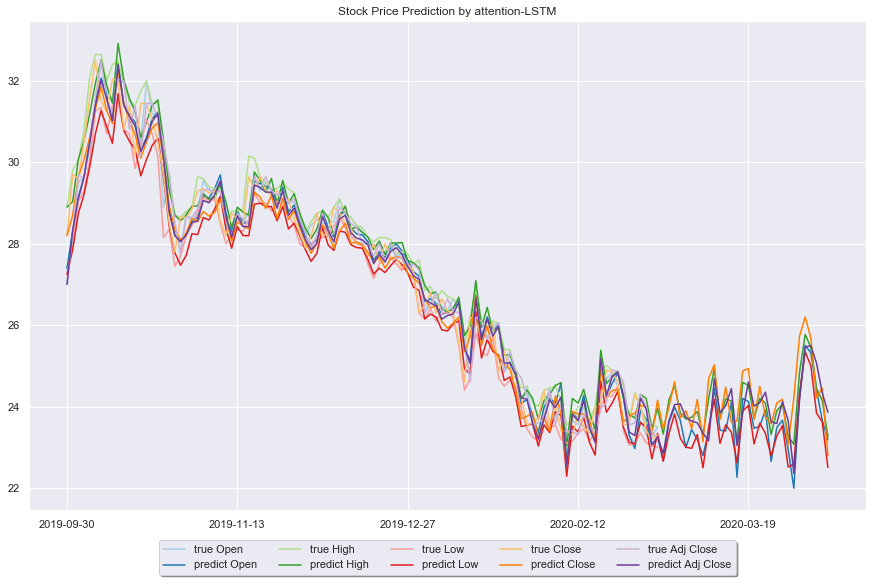

In [28]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])

ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    df_log[:, 0],
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    df_log[:, 1],
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    df_log[:, 2],
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    df_log[:, 3],
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    df_log[:, 4],
    label = 'predict Adj Close',
    color = current_palette[9],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('Stock Price Prediction by attention-LSTM')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

In [34]:
data = pd.read_csv('../dataset/BUD_HK.csv')
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime
data['real_date']=data['trade_date'].apply(time2stamp)
data=data.sort_values(by='real_date')
data.reset_index(inplace=True,drop=True)
times=data['trade_date'].values

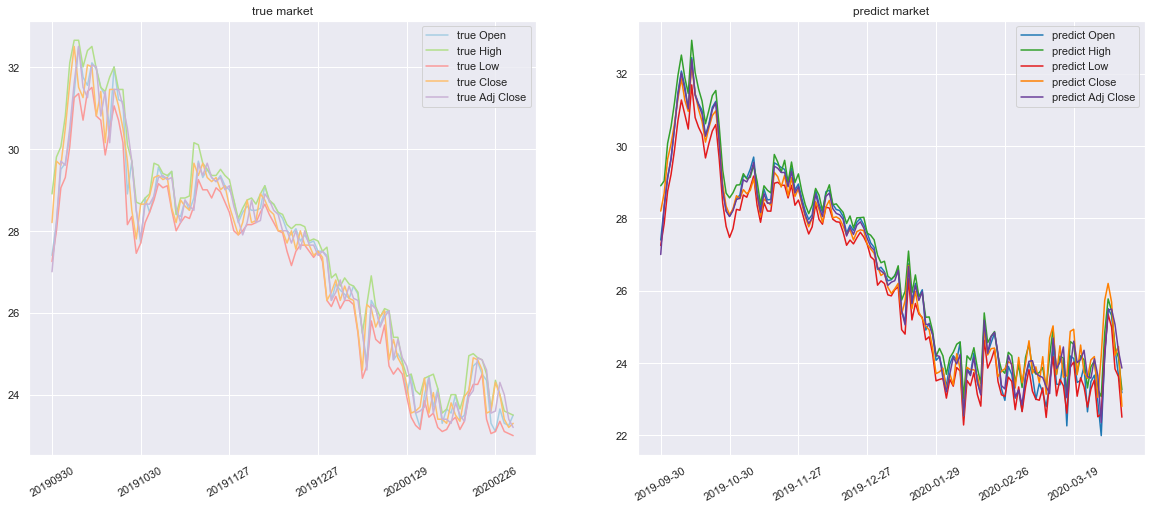

In [35]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(np.arange(len(times))[::20], times[::20],rotation=30)
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    df_log[:, 0],
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    df_log[:, 1],
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    df_log[:, 2],
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    df_log[:, 3],
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    df_log[:, 4],
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::20], date_ori[::20],rotation=30)
plt.legend()
plt.title('predict market')
plt.show()

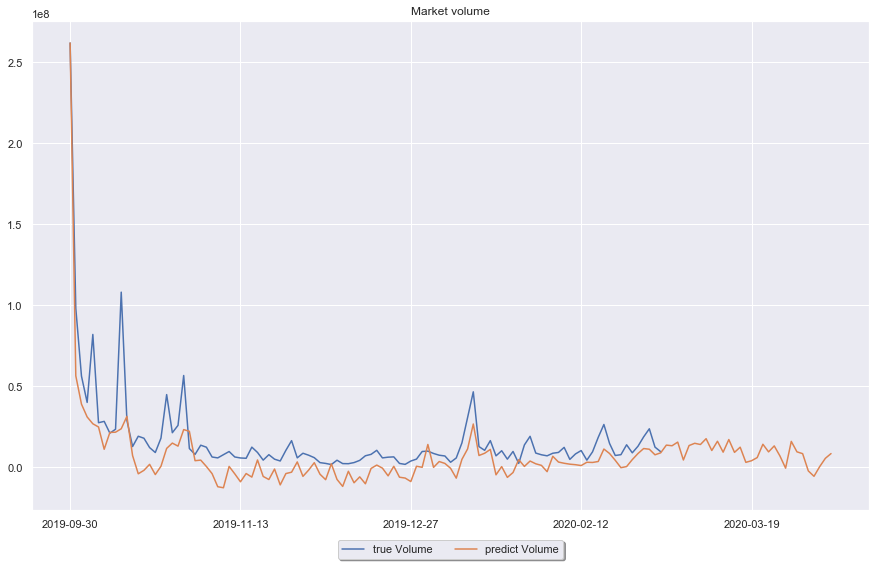

In [37]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('Market volume')
plt.show()